# Assignment 08 - Avengers Network Analysis

**Notebook Created by Professor [Brian Keegan](https://www.brianckeegan.com)**

**Notebook Completed by Spencer Fairbairn**

**[Department of Information Science, CU Boulder](www.colorado.edu/cmci/academics/information-science)**  
This notebook is copyright and made available under the [Apache License v2.0](https://creativecommons.org/licenses/by-sa/4.0/) license.

## Objectives

The objectives of this lab assignment are:

1. To become familiar with visualizing network data in Gephi
2. Using `networkx` to analyze the structural features of a network
3. Using other Python methods and tools like `pandas` to create networks
4. Handling bipartite networks by using bipartite-specific metrics or converting to unipartite graphs.

Load up the data analysis libraries we'll use.

In [1]:
import numpy as np
import pandas as pd

import networkx as nx

import os

import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#Worked on this assignment with Zach Lyons

## Analyze the Marvel Comic data

The [Marvel comic book universe](http://marvel.wikia.com/wiki/Marvel_Database) has spawned an [enormously profitable](http://www.boxofficemojo.com/franchises/chart/?id=avengers.htm) series of movie franchises. This data was taken from the [Marvel Comic Social Graph](http://syntagmatic.github.io/exposedata/marvel/) and is a bipartite graph with the "CHARACTER" and the "COMIC" in which they appeared.

In [4]:
marvel_df = pd.read_csv('marvel_hero_volume.csv',header=None)
print("There are {0:,} rows of data in marvel_df.".format(len(marvel_df)))

# Give some column names
marvel_df.columns = ['character','comic']

# There's a "BLADE" and "SABRE" in both "character" and "comic", so let's clear each up
marvel_df.replace({'character':{'BLADE':'BLADE (char)','SABRE':'SABRE (char)'},
                   'comic':{'BLADE':'BLADE (comic)','SABRE':'SABRE (comic)'}},inplace=True)

# Make a new column for aggregation purposes a few steps from now
marvel_df['weight'] = 0

# Inspect
marvel_df.head()

There are 96,655 rows of data in marvel_df.


,character,comic,weight
0,"FROST, CARMILLA",AA2 35,0
1,KILLRAVEN/JONATHAN R,AA2 35,0
2,M'SHULLA,AA2 35,0
3,24-HOUR MAN/EMMANUEL,AA2 35,0
4,OLD SKULL,AA2 35,0


Perform a groupby on the "character" and "comic" columns, aggregate using the `len` function on the "weight" column, and reset the index to create an edgelist. Save the resulting aggregation as `marvel_el`.

In [5]:
marvel_el =  marvel_df.groupby(['character', 'comic']).agg({'weight': len}).reset_index()
marvel_el.head()

,character,comic,weight
0,24-HOUR MAN/EMMANUEL,AA2 35,1
1,3-D MAN/CHARLES CHAN,AVF 4,1
2,3-D MAN/CHARLES CHAN,AVF 5,1
3,3-D MAN/CHARLES CHAN,COC 1,1
4,3-D MAN/CHARLES CHAN,H2 251,1


Using the `from_pandas_edgelist` function, make an undirected bipartite graph `marvel_bg` from `marvel_el`, passing the "weight" columns to "edge_attr". Include a print statement for the number of nodes and edges in `marvel_bg`.

In [84]:
#found on notebook 33
marvel_bg = nx.from_pandas_edgelist(marvel_el,
                                            source = 'character',
                                            target = 'comic',
                                            edge_attr = ['weight'],
                                            create_using = nx.Graph()
                                           )
marvel_bg.number_of_nodes()

19293

Use the `is_bipartite` function to confirm `marvel_bg` is bipartite.

In [7]:
nx.bipartite.is_bipartite(marvel_bg)

True

Make the node sets `marvel_character_ns` and `marvel_comic_ns` for the character and comic nodes so that we can perform bipartite analyses. Print out the number of nodes in each node set.

In [11]:
marvel_character_ns = marvel_df['character'].unique()
marvel_comic_ns = marvel_df['comic'].unique()

print(len(marvel_character_ns))
print(len(marvel_comic_ns))

6444
12849


Calculate the bipartite density of `marvel_bg`. How does this compare to the (**VERY INCORRECT**) unipartite density?

In [85]:
unipartite_density = nx.density(G = marvel_bg)
bipartite_density = nx.bipartite.density(B = marvel_bg, nodes = marvel_character_ns)

print("The unipartite (incorrect) density is: {0:.5f}\nThe bipartite (correct) density is: {1:.5f}".format(unipartite_density,bipartite_density))

The unipartite (incorrect) density is: 0.00052
The bipartite (correct) density is: 0.00117


Calculate the bipartite degree centralities of the nodes in `marvel_bg` and save as `marvel_bg_dc`.

In [86]:
marvel_bg_dc = nx.degree_centrality(marvel_bg)


The code below will turn the the `marvel_bg_dc` into a panda DataFrame `marvel_bg_metrics_df`.

In [87]:
# Turn the bipartite degree centrality into a DataFrame with one column called "degree"
marvel_bg_metrics_df = pd.DataFrame({'degree':marvel_bg_dc})

# Give the index a name
marvel_bg_metrics_df.index.name = 'node'

# Reset the index
marvel_bg_metrics_df.reset_index(inplace=True)

# Inspect
marvel_bg_metrics_df.head()

,node,degree
0,2001 10,0.000052
1,2001 8,0.000052
2,2001 9,0.000052
3,24-HOUR MAN/EMMANUEL,0.000052
4,3-D MAN/CHARLES CHAN,0.000467


Let's add a new column to `marvel_bg_metrics_df` called "type" that tells us the type of node for each row of data.

In [88]:
# Create an empty placeholder column
marvel_bg_metrics_df['type'] = np.nan

# Boolean index with .loc using each nodelist and fill the "type" column with the label
marvel_bg_metrics_df.loc[marvel_bg_metrics_df['node'].isin(marvel_character_ns),'type'] = 'character'
marvel_bg_metrics_df.loc[marvel_bg_metrics_df['node'].isin(marvel_comic_ns),'type'] = 'comic'

# Inspect
marvel_bg_metrics_df.head()

,node,degree,type
0,2001 10,0.000052,comic
1,2001 8,0.000052,comic
2,2001 9,0.000052,comic
3,24-HOUR MAN/EMMANUEL,0.000052,character
4,3-D MAN/CHARLES CHAN,0.000467,character


Sort `marvel_bg_dc` by "degree" in descending order. What are the 10 most-connected nodes?

In [89]:
sorted(marvel_bg_dc.items(),reverse=True,key=lambda x:x[1])
#Spiderman,Captain America, Iron Man, Thing, Thor, Human Torch, Mr. Fantastic, Hulk, Wolverine, Invisible Woman

[('SPIDER-MAN/PETER PAR', 0.08423180592991913),
 ('CAPTAIN AMERICA', 0.07008086253369272),
 ('IRON MAN/TONY STARK ', 0.060543230354551114),
 ('THING/BENJAMIN J. GR', 0.05131660792038151),
 ('THOR/DR. DONALD BLAK', 0.05002073398299814),
 ('HUMAN TORCH/JOHNNY S', 0.047066141405764046),
 ('MR. FANTASTIC/REED R', 0.045355587808418),
 ('HULK/DR. ROBERT BRUC', 0.04359319925357661),
 ('WOLVERINE/LOGAN ', 0.04250466514617458),
 ('INVISIBLE WOMAN/SUE ', 0.04053493676135186),
 ('BEAST/HENRY &HANK& P', 0.033433547584490984),
 ('SCARLET WITCH/WANDA ', 0.033381712626995644),
 ('DR. STRANGE/STEPHEN ', 0.032759693137051626),
 ('DAREDEVIL/MATT MURDO', 0.032396848434584284),
 ('WATSON-PARKER, MARY ', 0.03234501347708895),
 ('HAWK', 0.0316711590296496),
 ('VISION ', 0.03136014928467759),
 ('CYCLOPS/SCOTT SUMMER', 0.030893634667219574),
 ('WASP/JANET VAN DYNE ', 0.0306344598797429),
 ('JAMESON, J. JONAH', 0.03053078996475223),
 ('ANT-MAN/DR. HENRY J.', 0.029494090814845532),
 ('SUB-MARINER/NAMOR MA', 0.0

Calculate the bipartite clustering of the character nodes in `marvel_bg` and save as `marvel_bg_cluster_characters`. Do the analogous for comics, saving as `marvel_bg_cluster_comics`. This may take up to a minute.

In [80]:
marvel_bg_cluster_characters = nx.bipartite.clustering(marvel_bg)
marvel_bg_cluster_comics = nx.bipartite.clustering(marvel_bg)

The clustering was computed for the characters and comics separately. We'll concatenate this data together and put it into the `marvel_bg_metrics_df`.

In [90]:
# Convert to pandas Series, concatenate together, reset index
clustering_df = pd.concat([pd.Series(marvel_bg_cluster_characters),pd.Series(marvel_bg_cluster_comics)]).reset_index()

# Rename the columns
clustering_df.columns = ['node','clustering']

# Join the clustering_df and and marvel_bg_metrics_df data
marvel_bg_metrics_df = pd.merge(left=marvel_bg_metrics_df,right=clustering_df,left_on='node',right_on='node')

# Inspect
marvel_bg_metrics_df.head()

,node,degree,type,clustering
0,2001 10,0.000052,comic,0.203411
1,2001 10,0.000052,comic,0.203411
2,2001 8,0.000052,comic,0.203411
3,2001 8,0.000052,comic,0.203411
4,2001 9,0.000052,comic,0.203411


Boolean index `marvel_bg_metrics_df` to make two DataFrames with only comics (`marvel_bg_metrics_comic_df`) and character (`marvel_bg_metrics_character_df`) data.

In [93]:
marvel_bg_metrics_comic_df = marvel_bg_metrics_df[marvel_bg_metrics_df['type'] == 'comic']
marvel_bg_metrics_character_df = marvel_bg_metrics_df[marvel_bg_metrics_df['type'] =='character']

Now we will declutter like we did in Class 34 notebook. Group each of the two DataFrames you just made by degree, aggregate by average clustering, reset each index, and save as `marvel_bg_metrics_character_gb` and `marvel_bg_metrics_comic_df`.

In [94]:
#zach Lyons helped me with this
agg_f = {'clustering':np.mean}

marvel_bg_metrics_character_gb = marvel_bg_metrics_character_df.groupby('degree').agg(agg_f).reset_index()
marvel_bg_metrics_comic_gb = marvel_bg_metrics_comic_df.groupby('degree').agg(agg_f).reset_index()

Using the two DataFrames you just made, the code below should make a scatterplot with the "degree" on the x-axis and the "clustering" on the y-axis for each of the characters and comics.

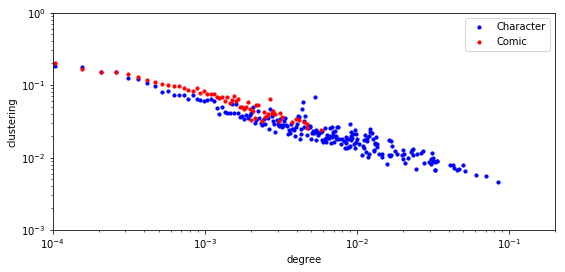

In [95]:
# Make the plot
f,ax = plt.subplots(1,1,figsize = (9,4))

marvel_bg_metrics_character_gb.plot(x='degree',y='clustering',kind='scatter',s=10,c='blue',ax=ax,label='Character')
marvel_bg_metrics_comic_gb.plot(x='degree',y='clustering',kind='scatter',s=10,c='red',ax=ax,label='Comic')

# Spruce up the plot
ax.set_xlim((1e-4,2e-1))
ax.set_ylim((1e-3,1e0))
ax.set_xscale('log')
ax.set_yscale('log')

We saw in the Class 34 notebook that clustering fell as degree increased. The data above examines *bipartite* clustering, such as whether characters have comics in common and whether comics have characters in common. Does the same pattern hold with this bipartite data as the unipartite data? Provide an explanation why poorly-connected character or comic nodes in this bipartite graph have higher clustering than well-connected character or comic nodes.

From this data we can see that both the Comics and Characters have the same general trend towards when the degree is higher the clustering is lower, and when the degree is lower the clustering is higher. From this we can see that it would have the same pattern from bipartite to unipartite. Next the reason why the poorly-connected character and comic nodes might be because of the more the character is in a comic the more people it is going to know and also the more people that they would know that wouldnt have as many conections.

## Analyze and visualize the projected Marvel comic data

Problem 2 explored the data as a bipartite (two-mode) network, but we can project this network down into a unipartite (one-mode) network.

Use the `weighted_projected_graph` function, project the `marvel_bg` onto the `marvel_character_ns`, saving as `marvel_character_g`.

In [53]:
marvel_character_g = nx.bipartite.weighted_projected_graph(B = marvel_bg, nodes = marvel_character_ns)

How many nodes and edges are in `marvel_character_g`?

In [56]:
print(marvel_character_g.number_of_nodes())
print(marvel_character_g.number_of_edges())

6444
167207


What is the density of `marvel_character_g`?

In [60]:
marvel_character_g_density = nx.density(marvel_character_g)
print(marvel_character_g_density)

0.00805454083187399


Compute the average neighbor degree and degree centrality for each node, and put these into a DataFrame called `marvel_character_g_metrics_df` with columns "degree" and "avg neighbor degree".

In [74]:
cha_degree_centrality = nx.degree_centrality(marvel_character_g)
cha_avg_neighbor_degree = nx.assortativity.average_neighbor_degree(marvel_character_g)


marvel_character_g_metrics_df = pd.DataFrame({'degree' : cha_degree_centrality, 'avg neighbor degree' : cha_avg_neighbor_degree})
marvel_character_g_metrics_df.head()

,avg neighbor degree,degree
24-HOUR MAN/EMMANUEL,26.200000,0.000776
3-D MAN/CHARLES CHAN,530.131148,0.018935
4-D MAN/MERCURIO,312.041667,0.011175
8-BALL/,31.714286,0.002173
A,547.625000,0.001242


As we did in Class 34 (and above), declutter the plot. Groupby the "degree", aggregate to the average "avg neighbor degree", reset the index, and save the aggregate DataFrame as `marvel_character_g_metrics_gb`.

In [100]:
agg_f = {'clustering':np.mean}

marvel_character_g_metrics_gb = marvel_character_g_metrics_df.groupby('degree').agg({'avg neighbor degree':np.mean}).reset_index()
marvel_character_g_metrics_gb.head()

,degree,avg neighbor degree
0,0.000000,0.000000
1,0.000155,691.603774
2,0.000310,475.476744
3,0.000466,356.294872
4,0.000621,386.650000


Make a scatterplot of the relationship with "degree" on the x-axis and "avg neighbor degree" on the y-axis. 

You may also want to add the following lines of code to see the relationship more clearly.

`ax.set_xlim((1e-4,1e0))
ax.set_xscale('log')`

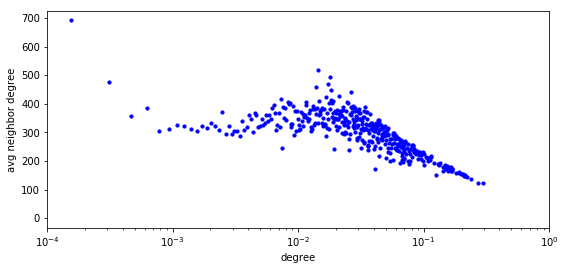

In [105]:
f,ax = plt.subplots(1,1,figsize = (9,4))

marvel_character_g_metrics_gb.plot(x='degree',y='avg neighbor degree',kind='scatter',s=10,c='blue', ax=ax)
ax.set_xlim((1e-4,1e0))
ax.set_xscale('log')

What relationship do you observe between the degree of character in the projected network and the degree of its neighbors? Is this the same as other social networks we examined in Class 34? Are well-connected nodes surrounded by other well-connected nodes or are well-connected nodes surrounded by poorly-connected nodes?

From this we can assume that people that have a higher degree such as captain america and spiderman have been in alot more comics that only portray an exra that doesnt meet to many characters so that is why the characters that have a lower degree but have a higher neighbor degree because these people have only been in one or two comics and their conections have met a bunch of people

Use the `degree_assortativity_coefficient` function on `marvel_character_g` to confirm your interpretation from the visualization.

In [107]:
nx.degree_assortativity_coefficient(marvel_character_g)

-0.16196840096976742

Use the code below to write the network out to a GEXF file.

In [106]:
nx.write_gexf(marvel_character_g,'marvel_character.gexf')

Make an *attractive* visualization of this network in Gephi (similar to Problem 1). This time, make sure to color the nodes by modularity class. Under the "Statistics" tab (typically located on the right side of "Overview"), click "Run" next to "Modularity", keep the defaults, hit "OK", and "Close" the "HTML Report" that pops up. Under Appearance (typically located on the upper left side of "Overview"), select Nodes", the paint palette, "Partition", choose "Modularity Class" from the drop-down, and click apply. You can experiment with different color palettes by clicking "Palette..." (in blue).

After you've finished tinkering with the layout, colors, sizes, *etc*., export the image as a PNG called `marvel_character.png` **IN THE SAME FOLDER AS THIS NOTEBOOK**. Triple check that the image file exported by Gephi is titled "marvel_character.png" and this "Assignment 08.ipynb" notebook file are saved in the same directory. Then run the cell below to import your network visualization into the Notebook.

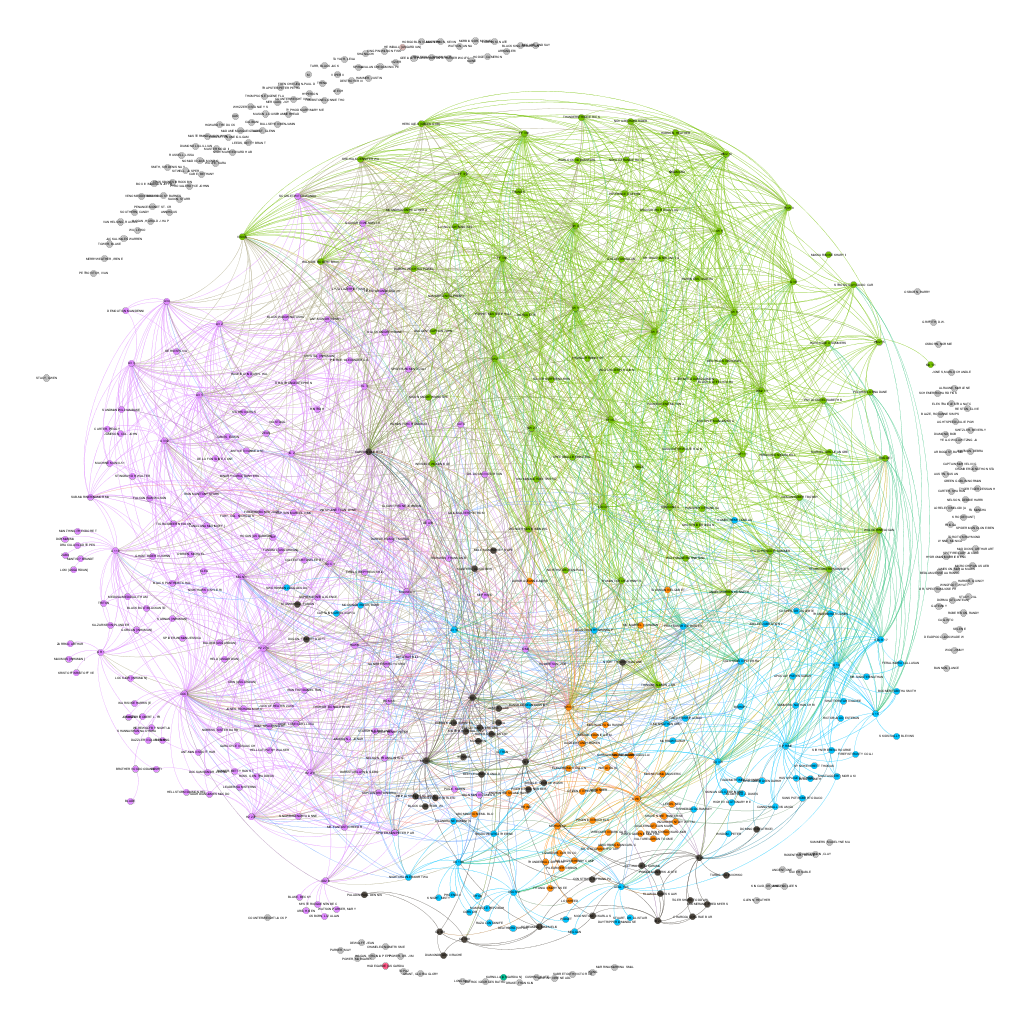

In [76]:
Image('New_Network.png')